In [1]:
""" Try finding the skull by just thresholding the bone out and finding how much there is in each slice """
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath("") + "/..")

img_dir = os.path.abspath("") + "/images/"
print(img_dir)
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

/home/mh19137/fish_test/localisation/images/


In [2]:
""" Read + display a jaw """
import numpy as np

img_no = 40
img = np.load(f"../tifs/{img_no}.npy")

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '125'}>,
         <Axes: title={'center': '250'}>, <Axes: title={'center': '375'}>],
        [<Axes: title={'center': '500'}>, <Axes: title={'center': '625'}>,
         <Axes: title={'center': '750'}>, <Axes: title={'center': '875'}>],
        [<Axes: title={'center': '1000'}>,
         <Axes: title={'center': '1125'}>,
         <Axes: title={'center': '1250'}>,
         <Axes: title={'center': '1375'}>],
        [<Axes: title={'center': '1500'}>,
         <Axes: title={'center': '1625'}>,
         <Axes: title={'center': '1750'}>,
         <Axes: title={'center': '1875'}>]], dtype=object))

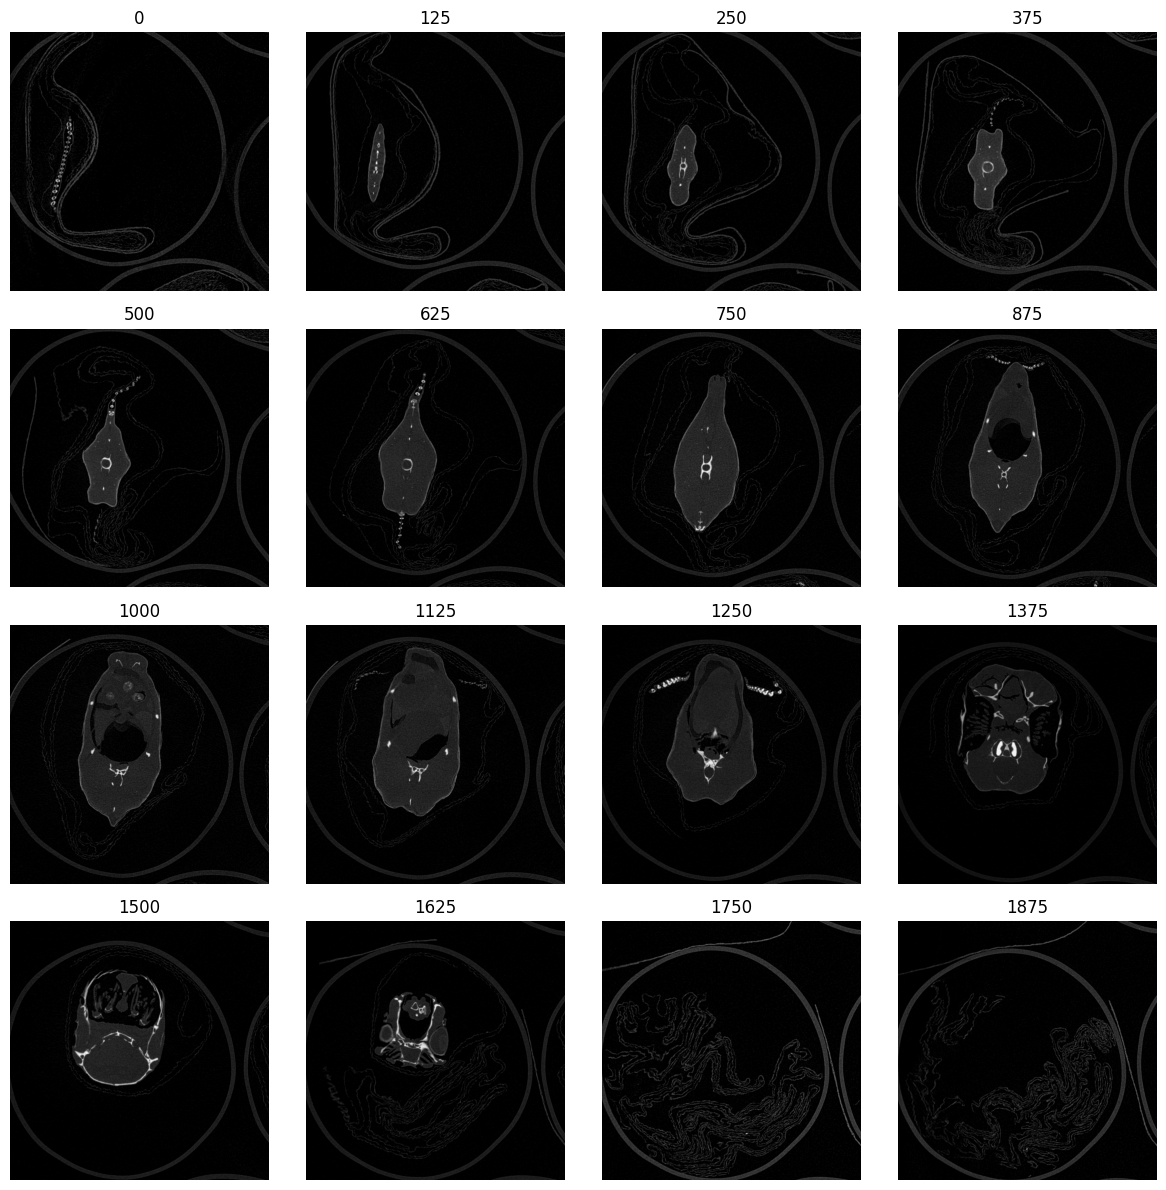

In [3]:
from dev import plot
plot.plot_arr(img)

In [4]:
""" Preprocess """
from dev import thresholding
saturated_pct = 0.35
equalised = thresholding.equalise(img, saturated_pct=saturated_pct)

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '125'}>,
         <Axes: title={'center': '250'}>, <Axes: title={'center': '375'}>],
        [<Axes: title={'center': '500'}>, <Axes: title={'center': '625'}>,
         <Axes: title={'center': '750'}>, <Axes: title={'center': '875'}>],
        [<Axes: title={'center': '1000'}>,
         <Axes: title={'center': '1125'}>,
         <Axes: title={'center': '1250'}>,
         <Axes: title={'center': '1375'}>],
        [<Axes: title={'center': '1500'}>,
         <Axes: title={'center': '1625'}>,
         <Axes: title={'center': '1750'}>,
         <Axes: title={'center': '1875'}>]], dtype=object))

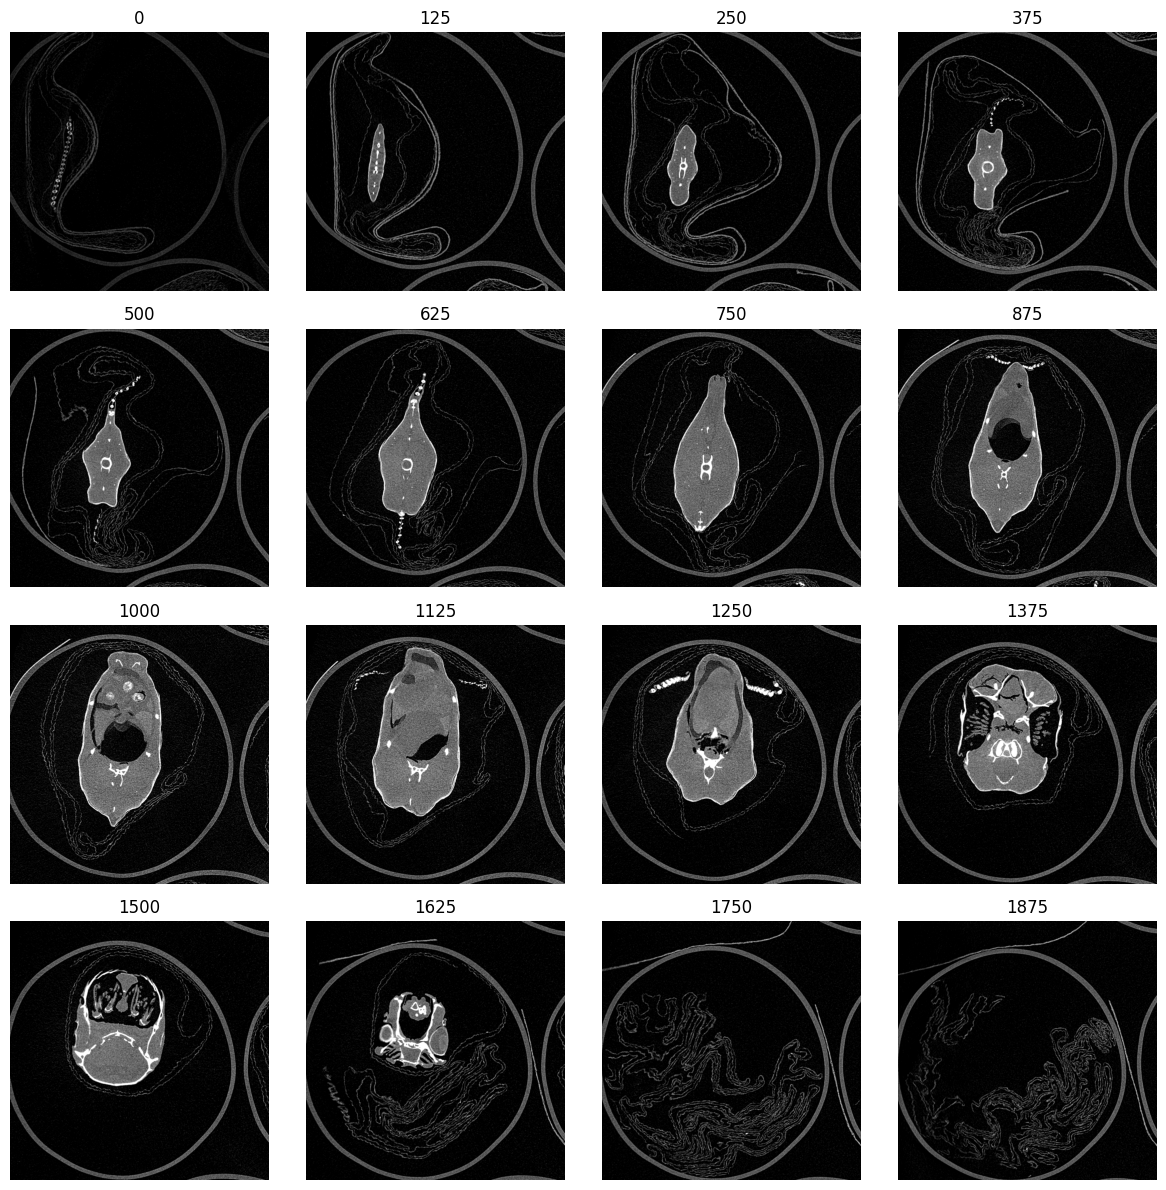

In [5]:
plot.plot_arr(equalised)

In [6]:
""" Threshold out, keeping only the brightest pixels """

threshold_pct = 0.45
value = np.quantile(equalised.flat, 1 - (threshold_pct / 100))
value

0.9047619047619048

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '125'}>,
         <Axes: title={'center': '250'}>, <Axes: title={'center': '375'}>],
        [<Axes: title={'center': '500'}>, <Axes: title={'center': '625'}>,
         <Axes: title={'center': '750'}>, <Axes: title={'center': '875'}>],
        [<Axes: title={'center': '1000'}>,
         <Axes: title={'center': '1125'}>,
         <Axes: title={'center': '1250'}>,
         <Axes: title={'center': '1375'}>],
        [<Axes: title={'center': '1500'}>,
         <Axes: title={'center': '1625'}>,
         <Axes: title={'center': '1750'}>,
         <Axes: title={'center': '1875'}>]], dtype=object))

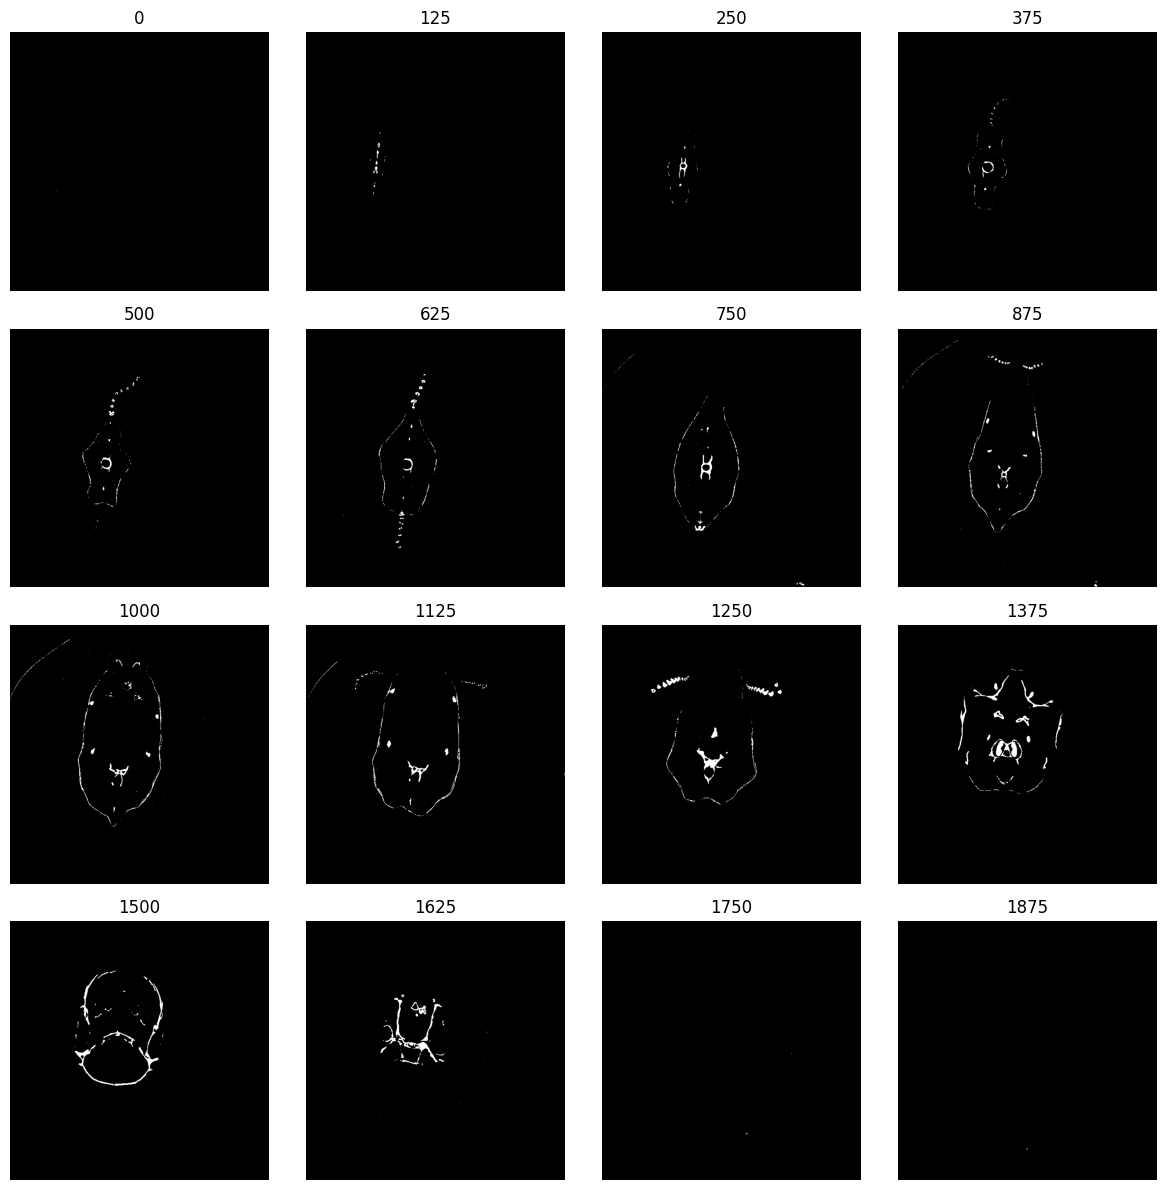

In [7]:
plot.plot_arr(equalised > value)

In [8]:
""" Count the number of pixels in each slice """
n_white = np.sum(equalised > value, axis=(1, 2))

Text(0.5, 1.0, 'Number of white pixels per slice for threshold 0.45%')

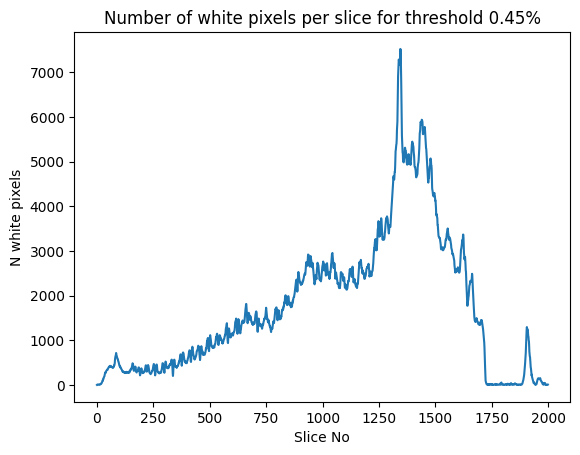

In [9]:
import matplotlib.pyplot as plt

plt.plot(n_white)

plt.xlabel("Slice No")
plt.ylabel("N white pixels")
plt.title(f"Number of white pixels per slice for threshold {threshold_pct}%")

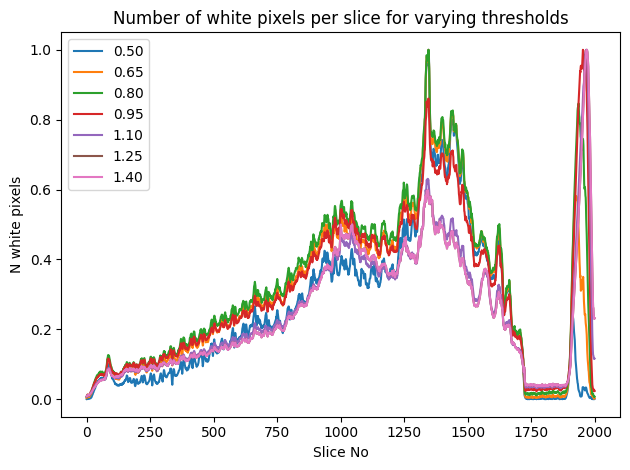

In [15]:
""" Vary the threshold for one image """


def n_white(equalised_array: np.ndarray, threshold_pct: float) -> np.ndarray:
    """
    Find the number of white pixels in each slice of the equalised array, using
    the given

    """
    value = np.quantile(equalised_array.flat, 1 - (threshold_pct / 100))

    return np.sum(equalised_array > value, axis=(1, 2))


x = np.zeros(img.shape[0])
step = 0.15
thresholds_pct = np.arange(saturated_pct + step, 1.5, step=step)
for threshold in thresholds_pct:
    n = n_white(equalised, threshold)

    # Scale to have the same max
    plt.plot(n / np.max(n), label=f"{threshold:.2f}")

    x += n

plt.legend()

plt.xlabel("Slice No")
plt.ylabel("N white pixels")
plt.title(f"Number of white pixels per slice for varying thresholds")

plt.tight_layout()

Text(0.5, 1.0, 'Number of white pixels per slice, averaged over thresholds')

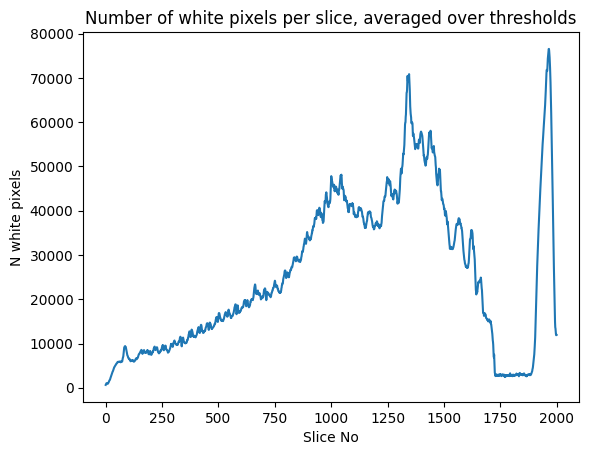

In [16]:
plt.plot(x)
plt.xlabel("Slice No")
plt.ylabel("N white pixels")

plt.title(f"Number of white pixels per slice, averaged over thresholds")

In [19]:
""" Try it for different fish """


def profile(img_no: int) -> np.ndarray:
    print(f"starting {img_no}")
    # Read the image
    img = np.load(f"../tifs/{img_no}.npy")

    # For each threshold, find the number of white pixels at each slice
    # As a function of quantiles
    x = np.zeros(img.shape[0])
    for threshold in thresholds_pct:
        n = n_white(img, threshold)
        x += n / np.max(n)

    print(f"done {img_no}")
    return x

In [22]:
from multiprocessing import Pool, Manager

res = Manager().dict()


def f(i):
    res[i] = profile(i)

nums = [40, 42, 70, 93, 577]
with Pool(6) as p:
    p.map(f, nums)

res

starting 40starting 93starting 70starting 42starting 577




done 70
done 93
done 42
done 40
done 577


<DictProxy object, typeid 'dict' at 0x7fda38a21040>

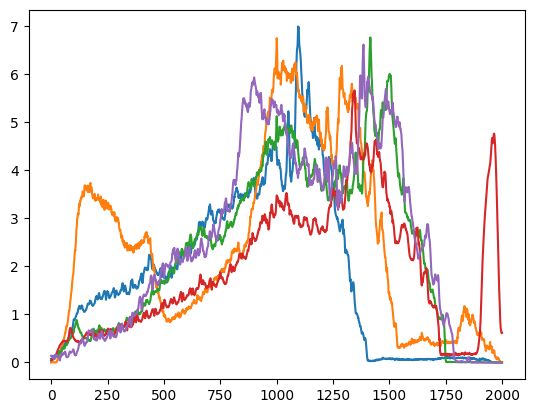

In [125]:
for i, v in res.items():
    plt.plot(v, label=i)

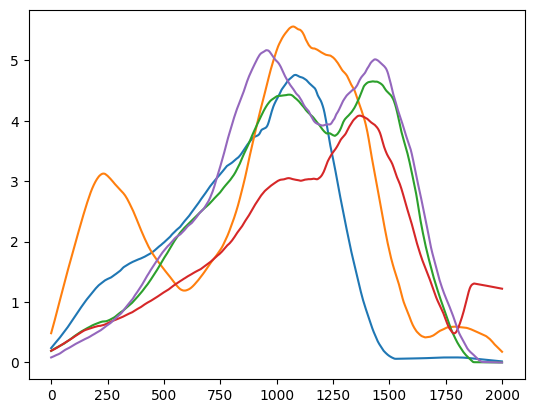

In [78]:
""" Make a very smoothed version """

n = 500
tophat = np.ones(n) / n

smoothed = {i: np.convolve(v, tophat, mode="same") for i, v in res.items()}

for i, v in smoothed.items():
    plt.plot(v, label=i)

In [128]:
""" Find where these smoothed ones are decreasing """


def decreasing_mask(profile: np.ndarray):
    """
    Find where the smoothed profile is decreasing

    """
    n = 500
    tophat = np.ones(n) / n
    smooth = np.convolve(profile, tophat, mode="same")

    return np.concatenate((np.diff(smooth) < 0, [False]))


def allowed_peak(profile: np.ndarray):
    """Filter out peaks that aren't allowed"""
    # Find where the slope of the smoothed curve is decreasing
    allowed = decreasing_mask(profile)

    # Find the ones that are near the beginning/end of the fish
    allowed[:250] = False
    allowed[-250:] = False

    # Find ones that are too small
    allowed[profile < 1] = False

    return allowed


allowed = {i: allowed_peak(v) for i, v in res.items()}

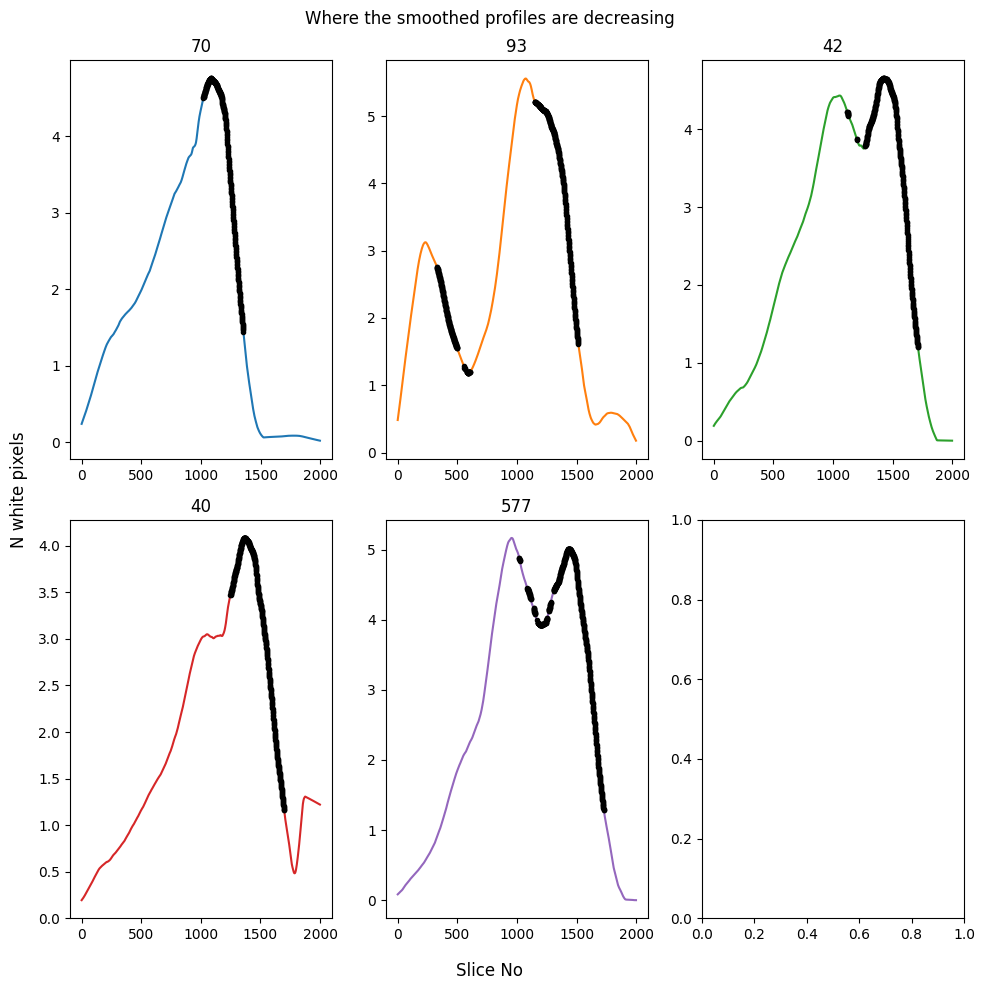

In [129]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

for j, ((i, v), axis) in enumerate(zip(smoothed.items(), axes.flat)):
    axis.plot(v, color=f"C{j}")

    # Find where this function is decreasing
    axis.plot(np.arange(len(allowed[i]))[allowed[i]], v[allowed[i]], "k.")

    axis.set_title(i)

fig.suptitle("Where the smoothed profiles are decreasing")
fig.supxlabel("Slice No")
fig.supylabel("N white pixels")

fig.tight_layout()

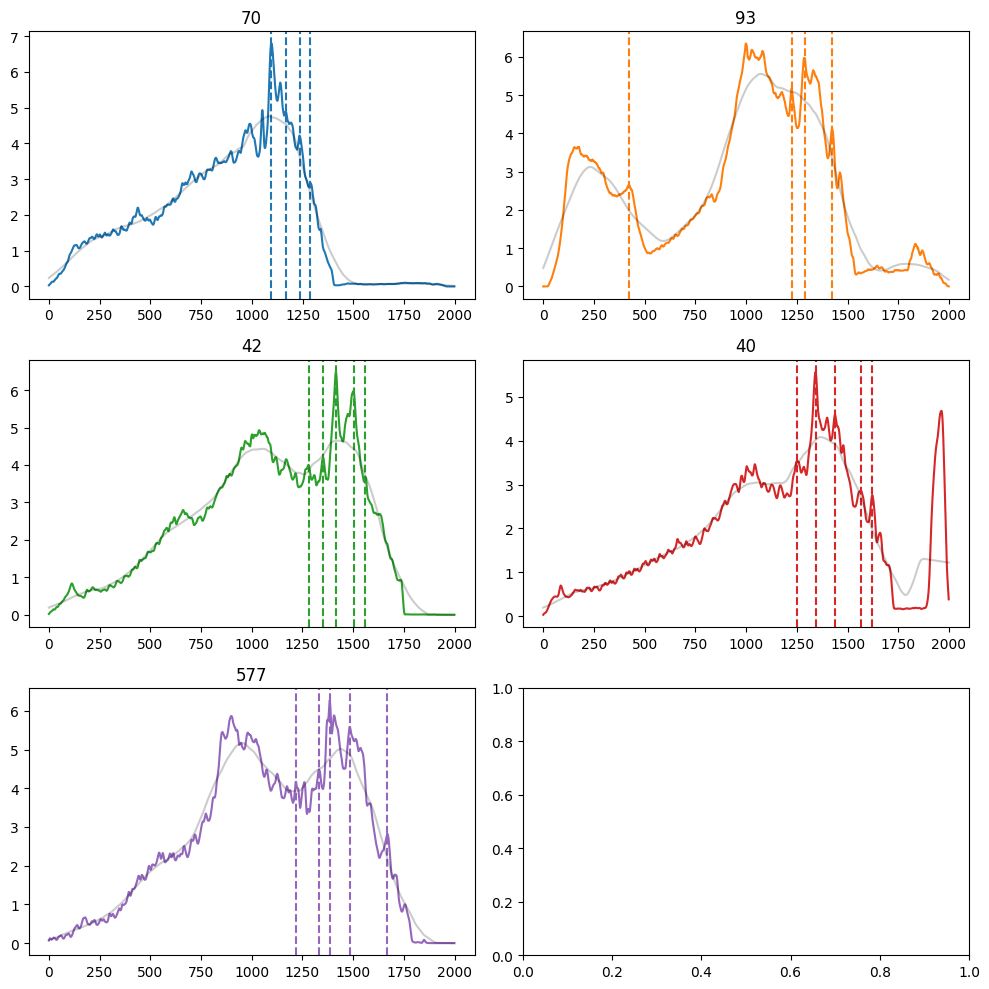

In [134]:
""" Find peaks """

from scipy.signal import find_peaks

width = 10
tophat = np.ones(width) / width
smooth = {n: np.convolve(v, tophat, mode="same") for n, v in res.items()}

peaks = {
    i: find_peaks(v, height=0.2, prominence=0.1, distance=50)[0]
    for i, v in smooth.items()
}

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for j, ((i, v), axis) in enumerate(zip(smooth.items(), axes.flat)):
    # Plot the original
    axis.plot(v, label=i, color=f"C{j}")

    # Plot the peaks that lie on decreasing parts
    for peak in peaks[i]:
        if allowed[i][peak]:
            axis.axvline(peak, color=f"C{j}", linestyle="--")

    # Plot the smoothed version
    axis.plot(smoothed[i], color="k", alpha=0.2)

    axis.set_title(i)

fig.tight_layout()

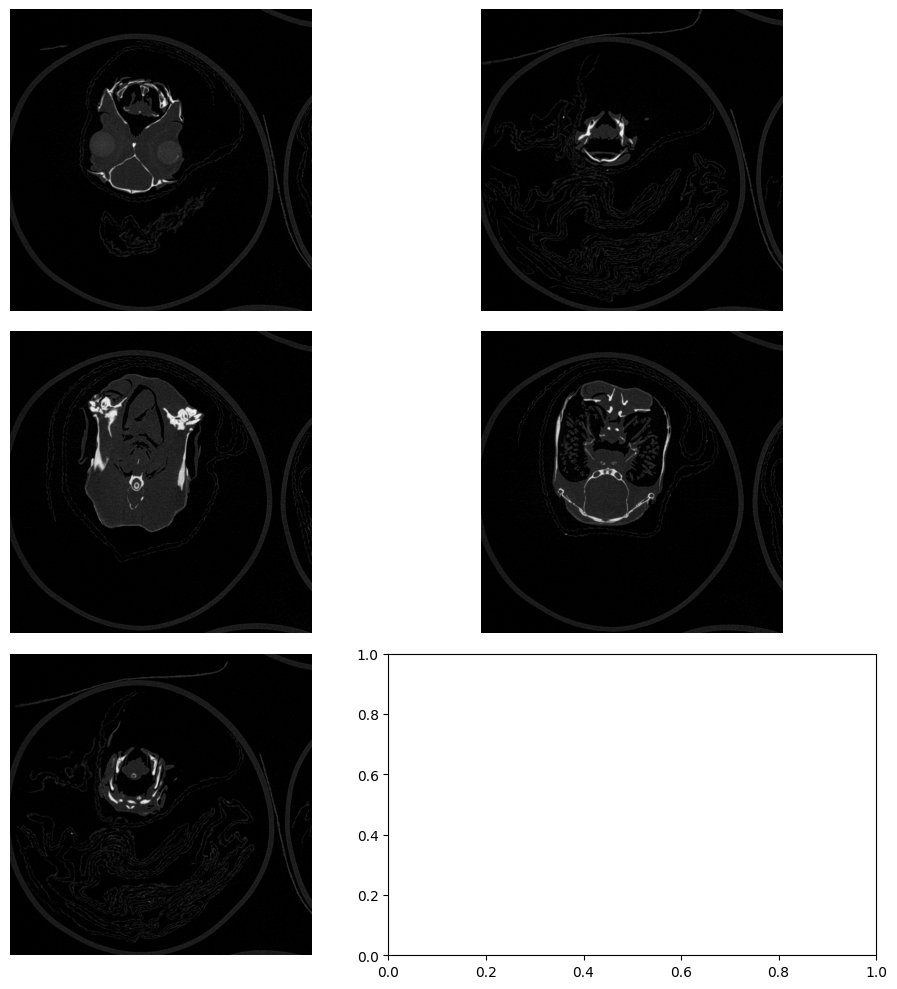

In [131]:
""" Choose the last peak, plot the Z slice at this location for each """

allowed_peaks = {i: [x for x in v if allowed[i][x]] for i, v in peaks.items()}

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

z_slices = {}

for num, axis in zip(nums, axes.flat):
    # Read the image
    img = np.load(f"../tifs/{img_no}.npy")

    # Choose the last peak
    img = img[allowed_peaks[num][-1]]
    z_slices[num] = img

    # Display this slice
    axis.imshow(img, cmap="gray")
    axis.set_axis_off()

fig.tight_layout()

In [135]:
""" Find a window that captures the most white pixels in our slices """

from scipy.signal import convolve


def find_max_subwindow(
    array, *, size: tuple[int, int] = (200, 200)
) -> tuple[np.ndarray, tuple[int, int]]:
    kernel = np.ones(size)

    # Step 2: Perform convolution to count the number of 1s in each sub-window
    conv_result = convolve(array, kernel, mode="valid")

    # Step 3: Find the index of the maximum value in the convolution result
    max_index = np.unravel_index(np.argmax(conv_result), conv_result.shape)

    # Step 4: Extract the sub-window using the index
    # Note: The end index is start index + size of the sub-window in each dimension
    sub_window = array[
        max_index[0] : min(max_index[0] + size[0], array.shape[0]),
        max_index[1] : min(max_index[1] + size[1], array.shape[1]),
    ]

    return sub_window, max_index

40 1566 (188, 168)
42 1688 (222, 133)
70 1338 (140, 178)
93 1424 (206, 157)
577 1669 (202, 153)


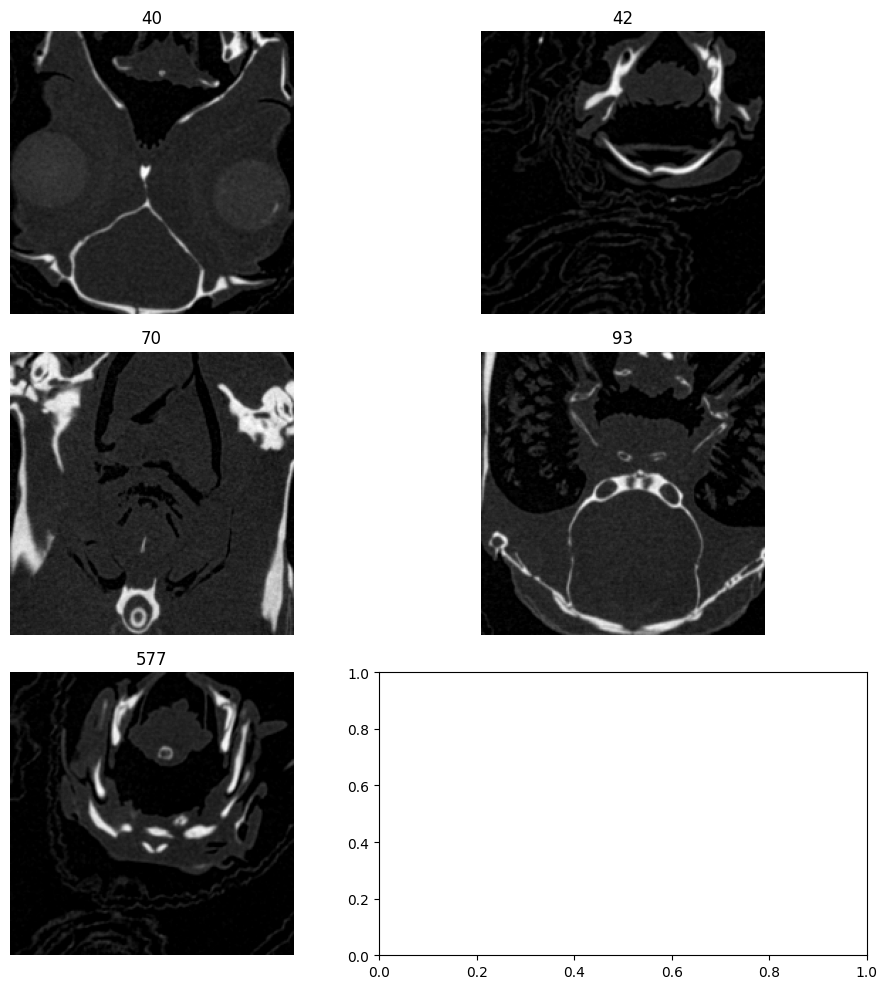

In [138]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for (i, slice_), axis in zip(z_slices.items(), axes.flat):
    sub_window, max_index = find_max_subwindow(slice_)
    print(i, allowed_peaks[i][-1], max_index)
    axis.imshow(sub_window, cmap="gray")
    axis.set_axis_off()
    axis.set_title(i)

fig.tight_layout()